
# Lecture 4 — Autoencoder, CNN & RNN (Theory + Practice)

本 Notebook 覆盖 Lec4 的主要理论要点，并配套 PyTorch 代码实践，结构如下：

1. Autoencoder 理论：基本结构、欠完备 / 过完备、自编码器的目标  
2. Denoising Autoencoder & Marginalized DAE 直觉  
3. 对抗样本与对抗训练（以图像分类为例，简单 FGSM）  
4. CNN 理论：卷积层、步长和填充、权重共享、池化层、1x1 卷积、整体架构  
5. CNN 实战：在 MNIST 上训练简单卷积网络  
6. RNN 理论：序列建模、递推公式、多种输入输出形式、梯度消失 / 爆炸、LSTM/GRU 概念  
7. RNN 实战：用 RNN 解决一个简单的序列分类任务  

> 运行前请确认：环境中已安装 `torch`, `torchvision`, `matplotlib`, `numpy`。

In [1]:

import math
import time
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')


## 1. Autoencoder 理论

**基本结构：**

- 输入：$$x \in \mathbb{R}^d$$
- 编码器（Encoder）：把高维输入映射到隐空间 $z$
  $$
  z = f_\theta(x)
  $$
- 解码器（Decoder）：从隐空间重建输入
  $$
  \hat x = g_\phi(z)
  $$
- 训练目标：让重建 $\hat x$ 尽量接近原始输入 $x$，典型损失：
  $$
  \mathcal{L}_{\text{rec}} = \|x - \hat x\|_2^2 \quad \text{或} \quad -\sum_i x_i \log \hat x_i
  $$

**欠完备 (undercomplete)** vs **过完备 (overcomplete)**：

- 欠完备：隐空间维度小于输入维度（有“瓶颈”），模型被迫学习**压缩后的有用表示**。
- 过完备：隐空间维度 >= 输入维度，如无正则，更容易学成“恒等映射”，难以泛化。

实际常配合各种正则化 / 结构约束：
- 稀疏约束（Sparse AE）  
- 去噪约束（Denoising AE）  
- 正交/平滑约束等。



### 1.1 一个简单的全连接 Autoencoder（MNIST）

- 使用 28×28 的手写数字图像（MNIST）。
- 编码：784 → 128 → 32 维隐空间。
- 解码：32 → 128 → 784，再 reshape 回图像。
- 损失函数：均方误差 (MSE)。

In [2]:

# 加载 MNIST 数据集
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset_full = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# 为了加快 Demo，这里只用训练集的前一部分
subset_size = 20000
train_dataset, _ = random_split(train_dataset_full, [subset_size, len(train_dataset_full) - subset_size])

batch_size = 256
train_loader_ae = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader_ae = DataLoader(test_dataset, batch_size=batch_size)

len(train_dataset), len(test_dataset)


(20000, 10000)

In [3]:

class FullyConnectedAE(nn.Module):
    def __init__(self, input_dim=28*28, hidden_dim=128, latent_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # 输出 [0,1]
        )

    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        recon = recon.view(x.size(0), 1, 28, 28)
        return recon, z

ae = FullyConnectedAE().to(device)
ae


FullyConnectedAE(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

In [4]:

# 训练 Autoencoder
def train_autoencoder(model, train_loader, test_loader, epochs=5, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        total_samples = 0
        for x, _ in train_loader:
            x = x.to(device)
            recon, _ = model(x)
            loss = loss_fn(recon, x)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_size = x.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size
        train_loss = total_loss / total_samples

        # 测试重建误差
        model.eval()
        total_loss_test = 0.0
        total_samples_test = 0
        with torch.no_grad():
            for x, _ in test_loader:
                x = x.to(device)
                recon, _ = model(x)
                loss = loss_fn(recon, x)
                batch_size = x.size(0)
                total_loss_test += loss.item() * batch_size
                total_samples_test += batch_size
        test_loss = total_loss_test / total_samples_test

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f"Epoch {epoch+1}: train_loss={train_loss:.4f}, test_loss={test_loss:.4f}")
    return train_losses, test_losses

train_losses_ae, test_losses_ae = train_autoencoder(ae, train_loader_ae, test_loader_ae, epochs=5, lr=1e-3)


Epoch 1: train_loss=0.0962, test_loss=0.0661
Epoch 2: train_loss=0.0568, test_loss=0.0469
Epoch 3: train_loss=0.0413, test_loss=0.0365
Epoch 4: train_loss=0.0336, test_loss=0.0302
Epoch 5: train_loss=0.0285, test_loss=0.0263


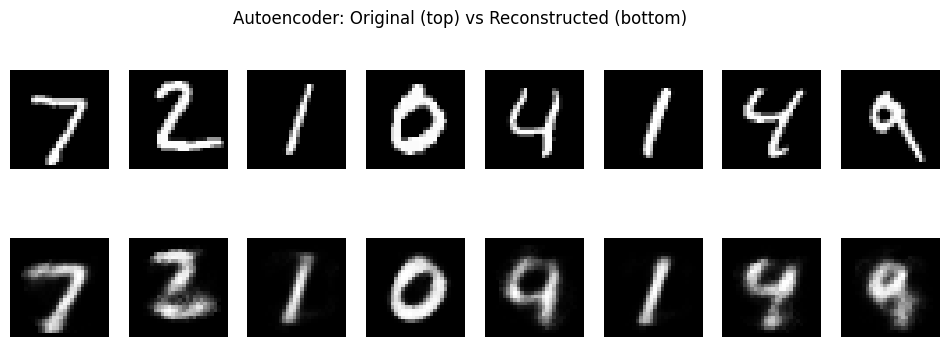

In [ ]:
# 可视化原图与重建图像
ae.eval()
x_batch, _ = next(iter(test_loader_ae))
x_batch = x_batch.to(device)
with torch.no_grad():
    recon_batch, _ = ae(x_batch)

x_batch = x_batch.cpu()
recon_batch = recon_batch.cpu()

n = 8
plt.figure(figsize=(12, 4))
for i in range(n):
    # 原图
    plt.subplot(2, n, i+1)
    plt.imshow(x_batch[i, 0], cmap="gray")
    plt.axis("off")
    # 重建
    plt.subplot(2, n, n+i+1)
    plt.imshow(recon_batch[i, 0], cmap="gray")
    plt.axis("off")
plt.suptitle("Autoencoder: Original (top) vs Reconstructed (bottom)")
plt.show()



## 2. Denoising Autoencoder & Marginalized DAE

### 2.1 Denoising Autoencoder (DAE)

思想：
- 不再要求自编码器简单地复制输入 $x$，而是先对输入加入噪声得到 $\tilde x$ ，
  $$
  \tilde x \sim q(\tilde x \mid x)
  $$
- 编码器接收的是 $\tilde x$，输出 $z = f_\theta(\tilde x)$；
- 解码器输出重建 $\hat x = g_\phi(z)$；
- 目标是让 $\hat x$ 接近**干净的** $x$：
  $$
  \mathcal{L}_{\text{DAE}} = \mathbb{E}_{q(\tilde x \mid x)} \|x - g_\phi(f_\theta(\tilde x))\|^2
  $$

直觉：
- 模型学到的是一种“从噪声中恢复干净数据”的映射 ⇒ 对输入扰动更鲁棒。  
- 可以理解为对数据流形 (manifold) 的一种“投影”操作。

常见噪声：
- 掩蔽噪声（Masking）：随机把一部分像素置 0。  
- 高斯噪声：$(\tilde x = x + \epsilon, \epsilon \sim \mathcal{N}(0,\sigma^2))$。

### 2.2 Marginalized Denoising Autoencoder (mDAE) 直觉

- 对于线性自编码器 + 高斯噪声，可以在数学上**解析地**把所有兼容噪声的期望写出来，
  得到一个闭式解，而不必显式地反复采样噪声。  
- 这就是“marginalized”（边缘化）：对噪声分布积分掉。

在实践中，我们通常直接用采样噪声 + SGD 训练 DAE 即可。


### 2.3 代码实践：Denoising Autoencoder（掩蔽噪声）

In [ ]:
class DenoisingAE(FullyConnectedAE):
    def __init__(self, input_dim=28*28, hidden_dim=128, latent_dim=32, noise_level=0.3):
        super().__init__(input_dim, hidden_dim, latent_dim)
        self.noise_level = noise_level

    def add_noise(self, x):
        # 掩蔽噪声：以 noise_level 的概率把像素置 0
        if self.noise_level <= 0.0:
            return x
        mask = (torch.rand_like(x) > self.noise_level).float()
        return x * mask

    def forward(self, x):
        noisy = self.add_noise(x)
        z = self.encoder(noisy)
        recon = self.decoder(z)
        recon = recon.view(x.size(0), 1, 28, 28)
        return recon, z, noisy

dae = DenoisingAE(noise_level=0.4).to(device)
dae


DenoisingAE(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

In [7]:

def train_denoising_ae(model, train_loader, test_loader, epochs=5, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        total_samples = 0
        for x, _ in train_loader:
            x = x.to(device)
            recon, _, _ = model(x)
            loss = loss_fn(recon, x)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_size = x.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size
        train_loss = total_loss / total_samples
        print(f"[DAE] Epoch {epoch+1}: train_loss={train_loss:.4f}")

train_denoising_ae(dae, train_loader_ae, test_loader_ae, epochs=3, lr=1e-3)


[DAE] Epoch 1: train_loss=0.0977
[DAE] Epoch 2: train_loss=0.0627
[DAE] Epoch 3: train_loss=0.0470


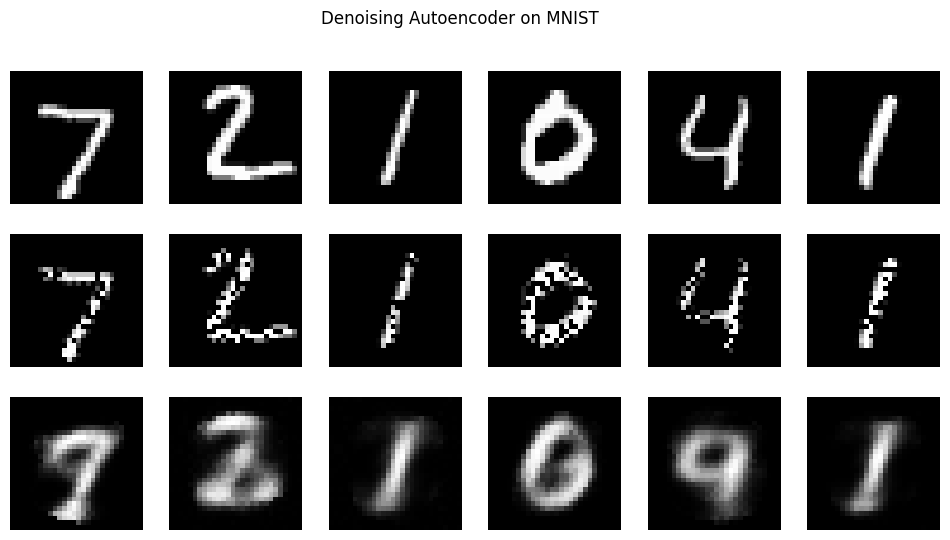

In [8]:

# 可视化原图、带噪图、以及 DAE 重建
dae.eval()
x_batch, _ = next(iter(test_loader_ae))
x_batch = x_batch.to(device)
with torch.no_grad():
    recon_batch, _, noisy_batch = dae(x_batch)

x_batch = x_batch.cpu()
noisy_batch = noisy_batch.cpu()
recon_batch = recon_batch.cpu()

n = 6
plt.figure(figsize=(12, 6))
for i in range(n):
    # 原图
    plt.subplot(3, n, i+1)
    plt.imshow(x_batch[i, 0], cmap="gray")
    plt.axis("off")
    if i == 0:
        plt.ylabel("Original")
    # 噪声图
    plt.subplot(3, n, n+i+1)
    plt.imshow(noisy_batch[i, 0], cmap="gray")
    plt.axis("off")
    if i == 0:
        plt.ylabel("Noisy")
    # 重建图
    plt.subplot(3, n, 2*n+i+1)
    plt.imshow(recon_batch[i, 0], cmap="gray")
    plt.axis("off")
    if i == 0:
        plt.ylabel("Reconstructed")
plt.suptitle("Denoising Autoencoder on MNIST")
plt.show()



## 3. 对抗样本与对抗训练

**对抗样本 (Adversarial Examples)**：
- 对输入 $x$ 加上一个人眼几乎察觉不到的小扰动 $\eta$，得到 $\tilde x = x + \eta$，
- 使得深度网络模型在 $\tilde x$ 上预测完全错误。

常见构造方式（FGSM：Fast Gradient Sign Method）：
$$
\tilde x = x + \epsilon \cdot \text{sign}\big(\nabla_x \mathcal{L}(f_\theta(x), y)\big)
$$
- $\epsilon$ 控制扰动大小。
- 直观：沿着“使损失增加最快的方向”在输入空间迈出一步。

**对抗训练 (Adversarial Training)**：
- 将对抗样本也加入训练：
  $$
  \min_\theta \; \mathbb{E}_{(x,y)} \big[ \max_{\|\eta\| \le \epsilon} \mathcal{L}(f_\theta(x + \eta), y) \big]
  $$
- 实现上常用近似：先按照当前参数构造一个或多个对抗样本，再用它们反向传播更新参数。

下面我们先训练一个小型 CNN 分类器，再用 FGSM 生成对抗样本做 Demo。


## 4. CNN 理论：卷积、步长、填充与池化

**卷积层核心思想：**
- **局部连接 (local connectivity)**：每个神经元只看输入的局部区域（感受野）。
- **权重共享 (weight sharing)**：同一个卷积核在整张图上滑动，使用同一组权重。

对一个输入体积 $W_1 \times H_1 \times D_1$，卷积层的超参数：
- 核大小 $F$（假设方形 $F \times F$）  
- 步长 $S$  
- 填充 $P$（zero padding）  
- 卷积核个数（输出通道数）$K$

输出体积大小：
$$
W_2 = \frac{W_1 - F + 2P}{S} + 1,\quad
H_2 = \frac{H_1 - F + 2P}{S} + 1,\quad
D_2 = K
$$

卷积层参数量：
- 每个卷积核有 $F \times F \times D_1$ 个权重 + 1 个 bias  
- 总参数 = $K \cdot (F \cdot F \cdot D_1 + 1)$。

**非线性层：**
- 在每个卷积层后应用 ReLU / Tanh / Sigmoid 等逐点非线性。

**池化层 (Pooling)：**
- 目的：减小空间分辨率、降低参数量、增加一定平移不变性。  
- 典型：Max Pooling (2×2, stride 2)，对每个通道的非重叠 2×2 区域取最大值。

**1×1 卷积：**
- 卷积核大小为 $1 \times 1$，但在通道维度上做线性变换；可用于：
  - 调整通道数（降维/升维）；
  - 增加非线性深度；
  - 不改变空间尺寸的情况下做“跨通道特征混合”。



### 4.1 在 MNIST 上训练一个简单 CNN

In [9]:

# 复用之前的 MNIST 数据，但为 CNN 构造 DataLoader
batch_size_cnn = 128
train_dataset_full_cnn = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset_cnn = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

val_ratio = 0.1
val_size = int(len(train_dataset_full_cnn) * val_ratio)
train_size = len(train_dataset_full_cnn) - val_size
train_dataset_cnn, val_dataset_cnn = random_split(train_dataset_full_cnn, [train_size, val_size])

train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=batch_size_cnn, shuffle=True)
val_loader_cnn = DataLoader(val_dataset_cnn, batch_size=batch_size_cnn)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=batch_size_cnn)

train_size, val_size, len(test_dataset_cnn)


(54000, 6000, 10000)

In [10]:

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # 28x28 -> 28x28
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                                   # 28x28 -> 14x14
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),# 14x14 -> 14x14
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                                   # 14x14 -> 7x7
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

def accuracy(preds, labels):
    return (preds.argmax(dim=1) == labels).float().mean().item()

cnn = SimpleCNN().to(device)
cnn


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [11]:

def evaluate(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    total_samples = 0
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = loss_fn(logits, y)
            batch_size = x.size(0)
            total_loss += loss.item() * batch_size
            total_acc += accuracy(logits, y) * batch_size
            total_samples += batch_size
    return total_loss / total_samples, total_acc / total_samples


In [12]:

def train_cnn(model, train_loader, val_loader, epochs=3, lr=1e-2, weight_decay=5e-4):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    train_losses, val_losses, val_accs = [], [], []
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        total_samples = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = loss_fn(logits, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_size = x.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size
        train_loss = total_loss / total_samples
        val_loss, val_acc = evaluate(model, val_loader, loss_fn, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        print(f"[CNN] Epoch {epoch+1}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc*100:.2f}%")
    return train_losses, val_losses, val_accs

train_losses_cnn, val_losses_cnn, val_accs_cnn = train_cnn(cnn, train_loader_cnn, val_loader_cnn, epochs=3, lr=0.01)


[CNN] Epoch 1: train_loss=0.5711, val_loss=0.1602, val_acc=94.88%
[CNN] Epoch 2: train_loss=0.1053, val_loss=0.0862, val_acc=97.37%
[CNN] Epoch 3: train_loss=0.0730, val_loss=0.0630, val_acc=97.98%


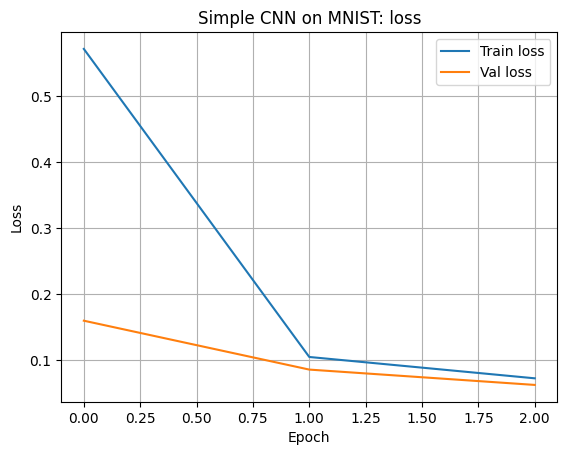

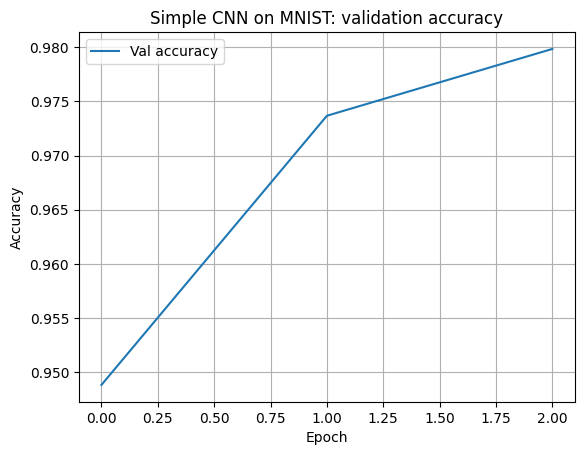

In [13]:

plt.figure()
plt.plot(train_losses_cnn, label="Train loss")
plt.plot(val_losses_cnn, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Simple CNN on MNIST: loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(val_accs_cnn, label="Val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Simple CNN on MNIST: validation accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [14]:

loss_fn = nn.CrossEntropyLoss()
test_loss_cnn, test_acc_cnn = evaluate(cnn, test_loader_cnn, loss_fn, device)
print(f"Test loss: {test_loss_cnn:.4f}, Test accuracy: {test_acc_cnn*100:.2f}%")


Test loss: 0.0520, Test accuracy: 98.32%



### 4.2 对抗攻击 Demo：FGSM on CNN

我们使用上面训练好的 CNN，在 MNIST 上构造 FGSM 对抗样本：

$$
x_{\text{adv}} = x + \epsilon \cdot \text{sign}\big(\nabla_x \mathcal{L}(f_\theta(x), y)\big)
$$

这个FGSM算法能生成对抗样本的原理很深刻，让我详细解释：

## FGSM的核心思想



x_adv = x + epsilon * sign(∇_x L(f_θ(x), y))



这个公式背后的逻辑是：

## 1. 梯度指向损失增加最快的方向

**梯度的含义**：
- `∇_x L` 告诉我们：在输入空间中，哪个方向上微小变化会让损失函数增加最快
- 每个像素位置的梯度值表示：如果增加该像素值，损失会增加多少

**直观理解**：


如果某个像素的梯度为正：增加该像素值 → 损失增加 → 预测更可能错误
如果某个像素的梯度为负：减少该像素值 → 损失增加 → 预测更可能错误



## 2. 符号函数的作用



grad_sign = x_adv.grad.data.sign()  # 只保留梯度的方向，丢弃大小



**为什么只要符号**：
- 我们只关心"朝哪个方向扰动"，不关心"扰动多大"
- `epsilon` 统一控制扰动幅度，确保人眼看不出差异

## 3. 数学推导

假设模型在点 `x` 附近可以线性近似：


In [ ]:
L(x + δ) ≈ L(x) + ∇_x L · δ



要让损失最大化，我们需要：


In [ ]:
max ||δ||_∞ ≤ ε  ∇_x L · δ



根据 Cauchy-Schwarz 不等式，当：


In [ ]:
δ = ε · sign(∇_x L)

时，内积达到最大值。

## 4. 为什么这样有效？

**深度网络的脆弱性**：


深度网络在高维空间中的决策边界往往不够平滑
即使是微小的、精心设计的扰动也能穿越决策边界



**可视化例子**：


原始图片：数字"3"，模型预测概率分布：[0.01, 0.02, 0.03, 0.89, ...]
加入FGSM扰动后：看起来仍像"3"，但预测变成：[0.02, 0.85, 0.01, 0.05, ...]



## 5. 实际攻击效果的原因

**模型过拟合的表现**：
- 模型在训练数据上过度优化，导致决策边界过于复杂
- 在输入空间的很多地方，微小变化就能改变预测

**高维空间的反直觉性**：
- 在高维空间（如28×28=784维）中，"微小扰动"的概念与人类直觉不符
- 每个维度的小变化累积起来，可能在模型看来是"显著"差异

## 6. 代码中的关键步骤



In [23]:
def fgsm_attack(model, x, y, epsilon=0.25):
    x_adv.requires_grad = True    # 1. 允许对输入求梯度
    
    logits = model(x_adv)         # 2. 前向传播
    loss = F.cross_entropy(logits, y)  # 3. 计算损失
    loss.backward()               # 4. 反向传播得到梯度
    
    grad_sign = x_adv.grad.data.sign()  # 5. 取梯度符号
    x_adv = x_adv + epsilon * grad_sign # 6. 沿梯度方向扰动
    
    return torch.clamp(x_adv, 0.0, 1.0) # 7. 确保像素值合法



这个算法揭示了深度学习模型的一个根本性脆弱性：**在人类无法察觉的扰动下，模型可能完全改变预测结果**。这也是为什么对抗训练如此重要的原因。

In [24]:

def fgsm_attack(model, x, y, epsilon=0.25):
    model.eval()
    x_adv = x.clone().detach().to(device)
    y = y.to(device)
    x_adv.requires_grad = True

    logits = model(x_adv)
    loss = F.cross_entropy(logits, y)
    model.zero_grad()
    loss.backward()

    # 取梯度符号
    grad_sign = x_adv.grad.data.sign()
    x_adv = x_adv + epsilon * grad_sign
    x_adv = torch.clamp(x_adv, 0.0, 1.0)
    return x_adv.detach()

# 抽一个 batch 看对抗攻击效果
x_batch, y_batch = next(iter(test_loader_cnn))
x_batch = x_batch.to(device)
y_batch = y_batch.to(device)

cnn.eval()
with torch.no_grad():
    logits_clean = cnn(x_batch)
pred_clean = logits_clean.argmax(dim=1)

x_adv_batch = fgsm_attack(cnn, x_batch, y_batch, epsilon=0.25)
with torch.no_grad():
    logits_adv = cnn(x_adv_batch)
pred_adv = logits_adv.argmax(dim=1)

# 统计攻击成功率
success = (pred_clean == y_batch) & (pred_adv != y_batch)
print("Clean accuracy on this batch:", (pred_clean == y_batch).float().mean().item())
print("Adversarial accuracy on this batch:", (pred_adv == y_batch).float().mean().item())
print("Attack success rate on correctly classified samples:", success.float().sum().item() / (pred_clean == y_batch).float().sum().item())


Clean accuracy on this batch: 0.9921875
Adversarial accuracy on this batch: 0.1953125
Attack success rate on correctly classified samples: 0.8031496062992126


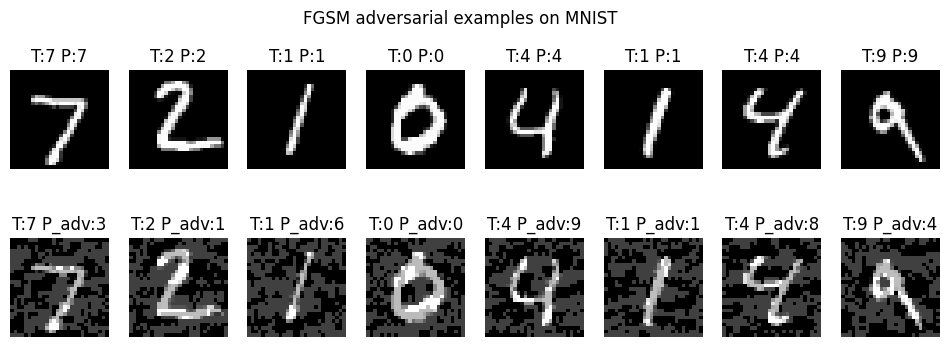

In [16]:

# 可视化若干原图与对抗图像及其预测
x_batch_cpu = x_batch.cpu()
x_adv_cpu = x_adv_batch.cpu()
y_cpu = y_batch.cpu()
pred_clean_cpu = pred_clean.cpu()
pred_adv_cpu = pred_adv.cpu()

n = 8
plt.figure(figsize=(12, 4))
for i in range(n):
    # 原图
    plt.subplot(2, n, i+1)
    plt.imshow(x_batch_cpu[i, 0], cmap="gray")
    plt.title(f"T:{y_cpu[i].item()} P:{pred_clean_cpu[i].item()}")
    plt.axis("off")
    # 对抗图
    plt.subplot(2, n, n+i+1)
    plt.imshow(x_adv_cpu[i, 0], cmap="gray")
    plt.title(f"T:{y_cpu[i].item()} P_adv:{pred_adv_cpu[i].item()}")
    plt.axis("off")
plt.suptitle("FGSM adversarial examples on MNIST")
plt.show()



## 5. RNN 理论：序列建模

RNN 适用于**序列数据**：文本、语音、时间序列等。

### 5.1 基本 RNN 单元

给定输入序列 $(x_1, x_2, \dots, x_T)$，RNN 的递推形式：
$$
h_t = \phi(W_{xh} x_t + W_{hh} h_{t-1} + b_h),\quad
y_t = W_{hy} h_t + b_y
$$
- $h_t$：时刻 $t$ 的隐藏状态，携带了到目前为止的历史信息。
- $\phi$：激活函数，如 Tanh / ReLU。

可以支持多种 I/O 形式：
- many-to-one：如情感分类（整句 -> 一个情感标签）。
- many-to-many：如序列标注、机器翻译等。

### 5.2 梯度消失 / 爆炸

- 反向传播通过时间 (Backprop Through Time, BPTT) 时，梯度会反复乘以 $W_{hh}$ 的若干次幂。
- 如果 $W_{hh}$ 的谱半径 < 1，则梯度可能快速衰减（梯度消失）；> 1 时则可能爆炸。

### 5.3 LSTM / GRU（高层次理解）

为缓解梯度消失 / 爆炸，引入门控结构：
- LSTM：输入门、遗忘门、输出门，显式维护“细胞状态” $c_t$，可以长时间保存信息。  
- GRU：把部分门合并，更轻量。

在 PyTorch 中，可以直接使用 `nn.RNN` / `nn.LSTM` / `nn.GRU`。


## 6. RNN 实战：序列奇偶性分类 (Parity)

我们构造一个简单任务：
- 输入：长度为 `seq_len` 的 0/1 序列；
- 输出：整个序列中 1 的个数是 **奇数** 还是 **偶数**（二分类）。

这是一个需要“记忆并累积信息”的任务，适合用 RNN 演示。

In [25]:

def generate_parity_dataset(num_samples=2000, seq_len=8):
    X = torch.randint(0, 2, (num_samples, seq_len)).float()  # 0 or 1
    y = (X.sum(dim=1) % 2).long()  # 0 = even, 1 = odd
    return X, y

seq_len = 8
num_samples = 5000
X, y = generate_parity_dataset(num_samples=num_samples, seq_len=seq_len)

# 划分 train / val / test
n_train = int(0.7 * num_samples)
n_val = int(0.15 * num_samples)
n_test = num_samples - n_train - n_val

X_train, y_train = X[:n_train], y[:n_train]
X_val, y_val = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test, y_test = X[n_train+n_val:], y[n_train+n_val:]

train_ds_rnn = TensorDataset(X_train, y_train)
val_ds_rnn = TensorDataset(X_val, y_val)
test_ds_rnn = TensorDataset(X_test, y_test)

batch_size_rnn = 64
train_loader_rnn = DataLoader(train_ds_rnn, batch_size=batch_size_rnn, shuffle=True)
val_loader_rnn = DataLoader(val_ds_rnn, batch_size=batch_size_rnn)
test_loader_rnn = DataLoader(test_ds_rnn, batch_size=batch_size_rnn)

len(train_ds_rnn), len(val_ds_rnn), len(test_ds_rnn)


(3500, 750, 750)

In [26]:

class SimpleRNNParity(nn.Module):
    def __init__(self, input_size=1, hidden_size=16, num_layers=1, num_classes=2):
        super().__init__()
        self.rnn = nn.RNN(input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True,
                          nonlinearity="tanh")
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x shape: (batch, seq_len)
        x = x.unsqueeze(-1)  # (batch, seq_len, 1)
        out, h_n = self.rnn(x)  # out: (batch, seq_len, hidden_size)
        last_hidden = out[:, -1, :]  # many-to-one: 取最后一个时刻的 hidden
        logits = self.fc(last_hidden)
        return logits

def evaluate_rnn(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    total_samples = 0
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = loss_fn(logits, y)
            batch_size = x.size(0)
            total_loss += loss.item() * batch_size
            preds = logits.argmax(dim=1)
            total_acc += (preds == y).float().sum().item()
            total_samples += batch_size
    return total_loss / total_samples, total_acc / total_samples

rnn_model = SimpleRNNParity().to(device)
rnn_model


SimpleRNNParity(
  (rnn): RNN(1, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=2, bias=True)
)

In [28]:

def train_rnn(model, train_loader, val_loader, epochs=20, lr=1e-2):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses, val_losses, val_accs = [], [], []
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        total_samples = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = loss_fn(logits, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_size = x.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size
        train_loss = total_loss / total_samples
        val_loss, val_acc = evaluate_rnn(model, val_loader, loss_fn, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        print(f"[RNN] Epoch {epoch+1}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc*100:.2f}%")
    return train_losses, val_losses, val_accs

train_losses_rnn, val_losses_rnn, val_accs_rnn = train_rnn(rnn_model, train_loader_rnn, val_loader_rnn, epochs=100, lr=1e-2)


[RNN] Epoch 1: train_loss=0.6939, val_loss=0.6948, val_acc=47.73%
[RNN] Epoch 2: train_loss=0.6937, val_loss=0.6938, val_acc=49.07%
[RNN] Epoch 3: train_loss=0.6937, val_loss=0.6946, val_acc=46.27%
[RNN] Epoch 4: train_loss=0.6938, val_loss=0.6940, val_acc=50.53%
[RNN] Epoch 5: train_loss=0.6934, val_loss=0.6950, val_acc=47.73%
[RNN] Epoch 6: train_loss=0.6942, val_loss=0.6934, val_acc=50.00%
[RNN] Epoch 7: train_loss=0.6943, val_loss=0.6933, val_acc=49.20%
[RNN] Epoch 8: train_loss=0.6941, val_loss=0.6936, val_acc=48.53%
[RNN] Epoch 9: train_loss=0.6937, val_loss=0.6932, val_acc=47.60%
[RNN] Epoch 10: train_loss=0.6943, val_loss=0.6950, val_acc=45.47%
[RNN] Epoch 11: train_loss=0.6941, val_loss=0.7130, val_acc=45.60%
[RNN] Epoch 12: train_loss=0.6937, val_loss=0.6968, val_acc=46.00%
[RNN] Epoch 13: train_loss=0.6935, val_loss=0.6929, val_acc=50.27%
[RNN] Epoch 14: train_loss=0.6934, val_loss=0.6936, val_acc=49.33%
[RNN] Epoch 15: train_loss=0.6932, val_loss=0.6934, val_acc=50.00%
[RNN

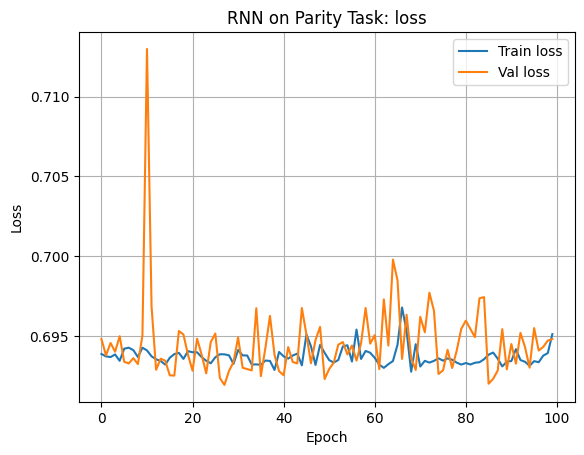

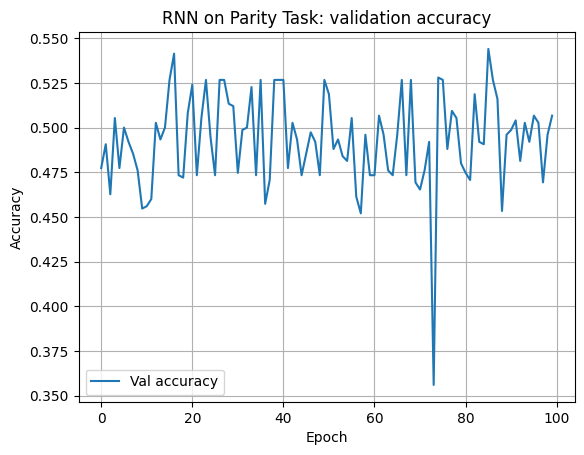

In [29]:

plt.figure()
plt.plot(train_losses_rnn, label="Train loss")
plt.plot(val_losses_rnn, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("RNN on Parity Task: loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(val_accs_rnn, label="Val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("RNN on Parity Task: validation accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [30]:

loss_fn = nn.CrossEntropyLoss()
test_loss_rnn, test_acc_rnn = evaluate_rnn(rnn_model, test_loader_rnn, loss_fn, device)
print(f"RNN Parity task - Test loss: {test_loss_rnn:.4f}, Test accuracy: {test_acc_rnn*100:.2f}%")


RNN Parity task - Test loss: 0.6942, Test accuracy: 49.47%



## 7. 总结 & 下一步可以做什么

本 Notebook 将 Lec4 的主要知识点转化为可运行代码：

1. **Autoencoder**
   - 基础 AE：理解“压缩再重建”的目标，体验重建效果。
   - Denoising AE：加入掩蔽噪声，让模型学会“去噪”，获得更鲁棒的表示。

2. **对抗样本 & 对抗训练（初步）**
   - 在训练好的 CNN 上使用 FGSM 构造对抗样本，观察预测从正确到错误。
   - 对抗训练的完整形式可以在此基础上扩展：用对抗样本参与训练。

3. **CNN**
   - 理清卷积层超参数 (F, S, P, K)、输出尺寸计算和参数量。
   - 在 MNIST 上训练一个小型卷积网络，了解卷积+池化+全连接的工作流程。

4. **RNN**
   - 从递推公式理解 RNN 处理序列数据的方式。
   - 用 RNN 解决一个简单的二分类序列任务（奇偶性），体会“记忆历史”的能力。

你可以在此基础上进一步：
- 把全连接 AE 换成卷积 AE；
- 对 CNN 添加 BatchNorm、更多层数，比较性能变化；
- 把 RNN 换成 LSTM 或 GRU，看看在更长序列上是否更稳定；
- 实现一个简单的对抗训练循环，对比“只用干净样本训练”和“加入对抗样本训练”的鲁棒性差异。